***Import all the libraries***

In [166]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE


# Preprocessing Steps
***Add the dataset and convert the date format to integer type.***

In [167]:
train_df = pd.read_csv('../data/cases_train_processed.csv')
test_df = pd.read_csv('../data/cases_test_processed.csv')

# Some preprocessing
# convert date from object type to int type
train_df["date_confirmation"] = pd.to_datetime(train_df["date_confirmation"]).dt.strftime("%Y%m%d").astype(int) 
test_df["date_confirmation"] = pd.to_datetime(test_df["date_confirmation"]).dt.strftime("%Y%m%d").astype(int) 


In [168]:
#use label encoder to normalize categorical features in dataframe
le = LabelEncoder()
categoricalFeatures = ['sex','province', 'country','key','additional_information', 'source']
for feat in categoricalFeatures:
    train_df[feat]= le.fit_transform(train_df[feat])
    test_df[feat]= le.fit_transform(test_df[feat])


In [169]:
y = train_df['outcome']
X = train_df.drop(['outcome'], axis=1)

In [170]:
#split data into training and validation sets
training_data, validation_data, training_truth, validation_truth = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=11)

***If there are null values in the test dataset, then fill them in with a -1 (placeholder)***

In [171]:
test_df.isnull().sum()

age                       0
sex                       0
province                  0
country                   0
latitude_x                0
longitude_x               0
date_confirmation         0
additional_information    0
source                    0
key                       0
latitude_y                3
longitude_y               3
confirmed_sum             3
death_sum                 3
recovered_sum             3
incidence_rate_avg        3
active_sum                3
Case-Fatality_Ratio       3
dtype: int64

In [172]:
test_df = test_df.fillna(-1)

***Using SMOTE for (partial) oversampling to solve the imbalanced labels problem.***

In [71]:
strategy = {'deceased':6000, 'recovered':100500, 'hospitalized':109000} 
oversampling = SMOTE(sampling_strategy=strategy,random_state=0)
training_data, training_truth = oversampling.fit_resample(training_data, training_truth)


In [72]:
training_truth.value_counts()

nonhospitalized    119928
hospitalized       109000
recovered          100500
deceased             6000
Name: outcome, dtype: int64

***Functions to calculate the recall, precision, and F1 score of the "deceased" label.***

In [11]:
# Scoring Functions
def calc_deceasedRecall(truth, prediction):
    return metrics.recall_score(truth,prediction, average=None)[0]

def calc_deceasedPrecision(truth, prediction):
    return metrics.precision_score(truth,prediction, average=None)[0]

def calc_deceasedF1(truth, prediction):
    return metrics.f1_score(truth,prediction, average=None)[0]


scoring_metrics = {
    'f1_deceased' : metrics.make_scorer(calc_deceasedF1),
    'recall_deceased' : metrics.make_scorer(calc_deceasedRecall),
    'overall_accuracy': metrics.make_scorer(metrics.accuracy_score),
    'overall_recall': metrics.make_scorer(metrics.recall_score , average='macro'),
}

# Hyperparameter Tuning
***Tuning the parameters and outputting the hyperparameter combinations as a dataframe.***
## 1. K-Nearest Neighbours Classifier

In [12]:
param_grid = {
    'n_neighbors': [9, 30, 50],
    'weights': ['distance','uniform'],
    'metric': ['euclidean']
    }

knn_model = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn_model, param_grid=param_grid, scoring=scoring_metrics, cv = 2, refit='f1_deceased', n_jobs = -1, verbose = -1)
knn_grid_search.fit(training_data, training_truth)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean'], 'n_neighbors': [9, 30, 50],
                         'weights': ['distance', 'uniform']},
             refit='f1_deceased',
             scoring={'f1_deceased': make_scorer(calc_deceasedF1),
                      'overall_accuracy': make_scorer(accuracy_score),
                      'overall_recall': make_scorer(recall_score, average=macro),
                      'recall_deceased': make_scorer(calc_deceasedRecall)},
             verbose=-1)

In [13]:

knn_results = pd.DataFrame(knn_grid_search.cv_results_)[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_f1_deceased', 'rank_test_f1_deceased', 'mean_test_recall_deceased', 'mean_test_overall_accuracy', 'mean_test_overall_recall']]


# Save as a csv file
knn_results.to_csv('../results/knn_params.csv')
knn_results

,param_n_neighbors,param_weights,param_metric,mean_test_f1_deceased,rank_test_f1_deceased,mean_test_recall_deceased,mean_test_overall_accuracy,mean_test_overall_recall
0,9,distance,euclidean,0.225773,1,0.165000,0.841930,0.676369
1,9,uniform,euclidean,0.181892,4,0.125333,0.833997,0.660764
2,30,distance,euclidean,0.214818,2,0.133167,0.846298,0.672542
3,30,uniform,euclidean,0.133662,5,0.073833,0.825817,0.642344
4,50,distance,euclidean,0.204695,3,0.125333,0.844873,0.669739
5,50,uniform,euclidean,0.102752,6,0.055333,0.816664,0.630860


## 2. Random Forests Classifier

In [14]:
#RF parameter grid
rf_param_grid = {
        'max_depth': [29, 30],
        'n_estimators': [200, 250],
        'max_features': [10, 12]
        }

In [15]:
rf_model = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_model, param_grid = rf_param_grid, scoring = scoring_metrics, cv = 3, refit = 'f1_deceased', n_jobs = -1)
rf_grid_search.fit(training_data, training_truth)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [29, 30], 'max_features': [10, 12],
                         'n_estimators': [200, 250]},
             refit='f1_deceased',
             scoring={'f1_deceased': make_scorer(calc_deceasedF1),
                      'overall_accuracy': make_scorer(accuracy_score),
                      'overall_recall': make_scorer(recall_score, average=macro),
                      'recall_deceased': make_scorer(calc_deceasedRecall)})

In [60]:
rf_results = pd.DataFrame(rf_grid_search.cv_results_)[['param_max_depth', 'param_n_estimators', 'param_max_features', 'mean_test_f1_deceased', 'rank_test_f1_deceased', 'mean_test_recall_deceased', 'mean_test_overall_accuracy', 'mean_test_overall_recall']]
# Save as a csv file
rf_results.to_csv('../results/rf_params.csv')
rf_results

,param_max_depth,param_n_estimators,param_max_features,mean_test_f1_deceased,rank_test_f1_deceased,mean_test_recall_deceased,mean_test_overall_accuracy,mean_test_overall_recall
0,29,200,10,0.226061,6,0.198833,0.840699,0.683288
1,29,250,10,0.224963,8,0.198000,0.840788,0.683150
2,29,200,12,0.227278,4,0.198667,0.840881,0.683345
3,29,250,12,0.228944,1,0.200333,0.840917,0.683863
4,30,200,10,0.227830,2,0.201000,0.840869,0.683907
5,30,250,10,0.225613,7,0.198333,0.840598,0.683154
6,30,200,12,0.226454,5,0.198167,0.840750,0.683204
7,30,250,12,0.227327,3,0.198833,0.840768,0.683313


## 3. LightGBM Classifier

In [17]:
#Parameter grid for LGBM
param_grid = {
    'num_leaves': [60,90,120],
    'n_estimators': [100,200,300],
    'min_data_in_leaf': [60,80]
    }

In [18]:
lgb_model = lgb.LGBMClassifier()
lgb_grid_search = GridSearchCV(lgb_model, param_grid=param_grid, scoring=scoring_metrics, cv=3, n_jobs=-1, refit='f1_deceased',verbose=-1)
lgb_grid_search.fit(training_data, training_truth)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'min_data_in_leaf': [60, 80],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [60, 90, 120]},
             refit='f1_deceased',
             scoring={'f1_deceased': make_scorer(calc_deceasedF1),
                      'overall_accuracy': make_scorer(accuracy_score),
                      'overall_recall': make_scorer(recall_score, average=macro),
                      'recall_deceased': make_scorer(calc_deceasedRecall)},
             verbose=-1)

In [19]:
# output the parameter variations and scores in a table
lgbm_results = pd.DataFrame(lgb_grid_search.cv_results_)[['param_num_leaves', 'param_n_estimators', 'param_min_data_in_leaf','mean_test_f1_deceased', 'rank_test_f1_deceased','mean_test_recall_deceased', 'mean_test_overall_accuracy','mean_test_overall_recall']]
# Save as a csv file
lgbm_results.to_csv('../results/lgbm_params.csv')
lgbm_results

,param_num_leaves,param_n_estimators,param_min_data_in_leaf,mean_test_f1_deceased,rank_test_f1_deceased,mean_test_recall_deceased,mean_test_overall_accuracy,mean_test_overall_recall
0,60,100,60,0.192803,15,0.150833,0.842291,0.673520
1,90,100,60,0.197291,13,0.161500,0.845296,0.678477
2,120,100,60,0.190844,16,0.169000,0.841060,0.676597
3,60,200,60,0.205710,8,0.167667,0.848242,0.682277
4,90,200,60,0.203626,9,0.178167,0.846033,0.682819
5,120,200,60,0.206582,5,0.188667,0.844327,0.683822
6,60,300,60,0.202030,10,0.180833,0.843558,0.681400
7,90,300,60,0.211058,3,0.193000,0.845284,0.685610
8,120,300,60,0.218102,1,0.201500,0.845719,0.687910
9,60,100,80,0.190832,17,0.147167,0.841951,0.672530


# Evaluating performance of tuned models
## 1. K-Nearest Neighbours

In [37]:
best_knn = KNeighborsClassifier(n_neighbors = 9, weights = 'distance', metric = 'euclidean')
best_knn.fit(training_data, training_truth)

KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')

In [38]:
training_prediction = best_knn.predict(training_data)
validation_prediction = best_knn.predict(validation_data)

In [152]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("K-Nearest Neighbours Model Predictions (Post-Hyperparameter Tuning):\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('\n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('\n',scores_validation)

K-Nearest Neighbours Model Predictions (Post-Hyperparameter Tuning):

TRAINING
Accuracy score: 0.86308

                  precision    recall  f1-score   support

       deceased       0.84      0.36      0.51      6000
   hospitalized       0.80      0.80      0.80    109000
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.78      0.80      0.79    100500

       accuracy                           0.86    335428
      macro avg       0.85      0.74      0.77    335428
   weighted avg       0.86      0.86      0.86    335428


VALIDATION
Accuracy score: 0.85578

                  precision    recall  f1-score   support

       deceased       0.40      0.12      0.19       913
   hospitalized       0.82      0.79      0.80     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.70      0.76      0.73     17643

       accuracy                           0.86     73526
      macro avg       0.73      0.67      0.68     735

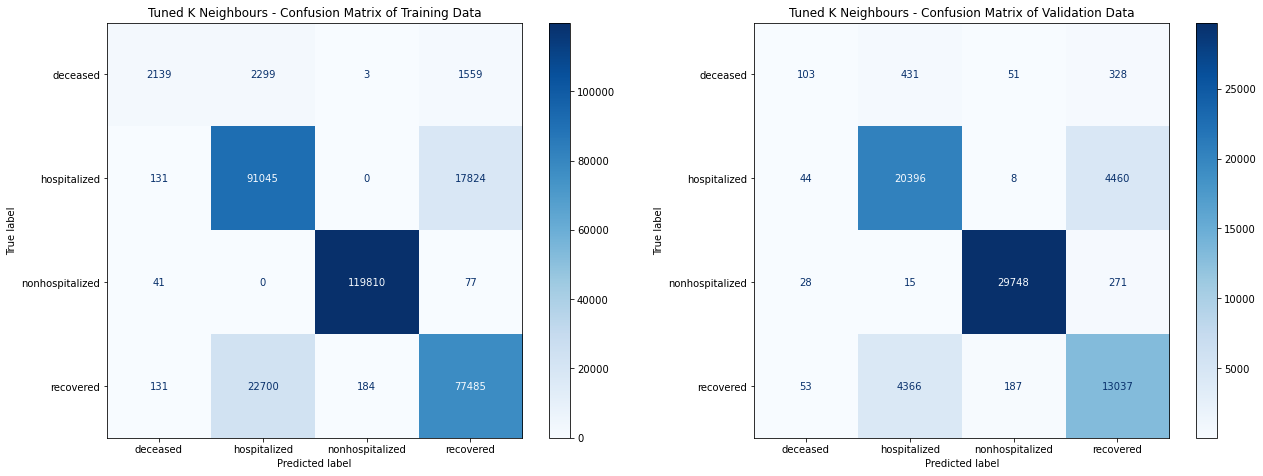

In [23]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(best_knn, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('Tuned K Neighbours - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(best_knn, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('Tuned K Neighbours - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
fig.savefig('../plots/knn_matrix.png', bbox_inches='tight', pad_inches=0.3)

## 2. Random Forest

In [57]:
# Fit the model on the training dataset
#best_rf = RandomForestClassifier(max_depth=29, n_estimators=200, max_features=10) - f1 score = 0.20
best_rf = RandomForestClassifier(max_depth=29, n_estimators=250, max_features=12) # -f1 score = 0.21
best_rf.fit(training_data, training_truth)

RandomForestClassifier(max_depth=29, max_features=12, n_estimators=250)

In [58]:
# predict on the training data
RF_training_prediction = best_rf.predict(training_data)
#predict on the validation data
RF_validation_prediction = best_rf.predict(validation_data)

In [153]:
training_accuracy = metrics.accuracy_score(RF_training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,RF_training_prediction)
validation_accuracy = metrics.accuracy_score(RF_validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,RF_validation_prediction)
print("Random Forest Model Predictions (Post-Hyperparameter Tuning):\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('\n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('\n',scores_validation)

Random Forest Model Predictions (Post-Hyperparameter Tuning):

TRAINING
Accuracy score: 0.87446

                  precision    recall  f1-score   support

       deceased       0.97      0.38      0.55      6000
   hospitalized       0.81      0.83      0.82    109000
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.80      0.81      0.80    100500

       accuracy                           0.87    335428
      macro avg       0.89      0.75      0.79    335428
   weighted avg       0.88      0.87      0.87    335428


VALIDATION
Accuracy score: 0.86333

                  precision    recall  f1-score   support

       deceased       0.56      0.13      0.21       913
   hospitalized       0.82      0.82      0.82     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.72      0.75      0.74     17643

       accuracy                           0.86     73526
      macro avg       0.77      0.67      0.69     73526
   w

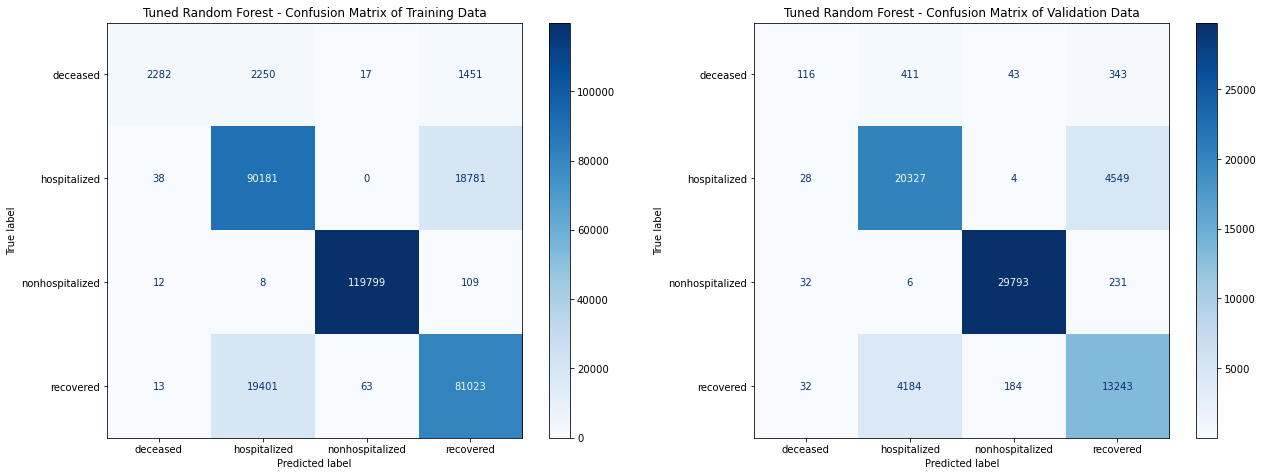

In [27]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(best_rf, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('Tuned Random Forest - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(best_rf, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('Tuned Random Forest - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
fig.savefig('../plots/rf_matrix.png', bbox_inches='tight', pad_inches=0.3)

## 3. LightGBM

In [28]:
# Fit the model on the training dataset
best_lgbm = lgb.LGBMClassifier(num_leaves = 120, n_estimators=300,min_data_in_leaf=60)
best_lgbm.fit(training_data, training_truth)

LGBMClassifier(min_data_in_leaf=60, n_estimators=300, num_leaves=120)

In [155]:
# predict on the training data
training_prediction = best_lgbm.predict(training_data)
#predict on the validation data
validation_prediction = best_lgbm.predict(validation_data)

### 3.2 Evaluating the model
*The metrics used to evaluate the model are the Accuracy score, Precision, Recall, F1-score, and the support count.*

In [156]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("LightGBM Model Predictions (Post-Hyperparameter Tuning):\n")
print('\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('\n',scores_training)
print('\n\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('\n',scores_validation)
# lgb.LGBMClassifier(num_leaves = 120, n_estimators=300,min_data_in_leaf=60)


LightGBM Model Predictions (Post-Hyperparameter Tuning):


Accuracy score: 0.87608

                  precision    recall  f1-score   support

       deceased       0.95      0.31      0.47      6000
   hospitalized       0.82      0.82      0.82    109000
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.80      0.82      0.81    100500

       accuracy                           0.88    335428
      macro avg       0.89      0.74      0.77    335428
   weighted avg       0.88      0.88      0.87    335428



Accuracy score: 0.87149

                  precision    recall  f1-score   support

       deceased       0.52      0.12      0.19       913
   hospitalized       0.83      0.82      0.83     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.73      0.78      0.75     17643

       accuracy                           0.87     73526
      macro avg       0.77      0.68      0.69     73526
   weighted avg       0.87 

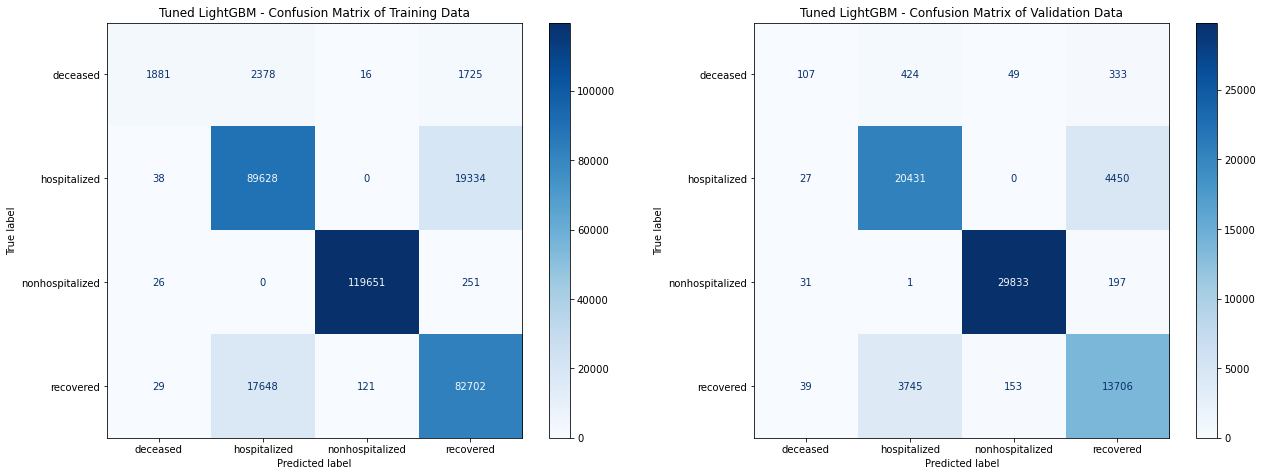

In [92]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(best_lgbm, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('Tuned LightGBM - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(best_lgbm, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('Tuned LightGBM - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
fig.savefig('../plots/lgbm_matrix.png', bbox_inches='tight', pad_inches=0.3)

## USING LIGHTGBM TO PREDICT OUTCOME LABELS ON CASES_TEST_PROCESSED

In [173]:
final_predictions = best_rf.predict(test_df)

In [174]:
# Random Forest
values, counts = np.unique(final_predictions, return_counts=True)
print(values)
print(counts)

['deceased' 'hospitalized' 'nonhospitalized' 'recovered']
[  222 15164 20066 11048]


In [175]:
with open(os.path.join('../results/','predictions.txt'), "w") as outfile:
    outfile.write("\n".join(final_predictions))

In [176]:
def check_if_file_valid(filename):
    assert filename.endswith('predictions.txt'), 'Incorrect filename' 
    f = open(filename).read()
    l = f.split('\n')
    assert len(l) == 46500, 'Incorrect number of items'
    assert (len(set(l)) == 4), 'Wrong class labels'
    return 'The predictions file is valid'

In [177]:
check_if_file_valid('../results/predictions.txt')

'The predictions file is valid'

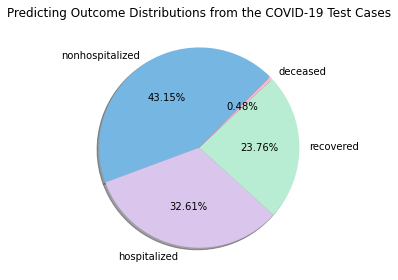

In [178]:
# RF
colour = ['#76b6e3', '#dac5ed','#b9edd3','#fabbd1']
labels = ['nonhospitalized','hospitalized','recovered','deceased']
counts = [20066,15164,11048,222]

plt.pie(counts, labels = labels,autopct='%1.2f%%',startangle=45, colors = colour,shadow = True)
# figure = outcomes.plot(kind='pie', shadow = True, title='The Outcome Distributions of all COVID-19 cases', autopct='%1.1f%%',startangle=45, colors = colour,figsize=(6, 5)).get_figure()
plt.title('Predicting Outcome Distributions from the COVID-19 Test Cases')
plt.tight_layout()
plt.savefig('../plots/pie_outcomes.png') # save output figure as an image